In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional,Dropout
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.text import one_hot

import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Import data

In [152]:
test_data = pd.read_csv("test.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
train_data = pd.read_csv("train.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
validation_data = pd.read_csv("val.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
print("Train : ", train_data.shape)
print("Test : ", test_data.shape)
print("Validation : ", validation_data.shape)

Train :  (16000, 2)
Test :  (2000, 2)
Validation :  (2000, 2)


In [33]:
train_data.head()

,Comment,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


I will first try to see if length of the comments is correlated to the emotion

In [153]:
train_data['length'] = [len(x) for x in train_data['Comment']]
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


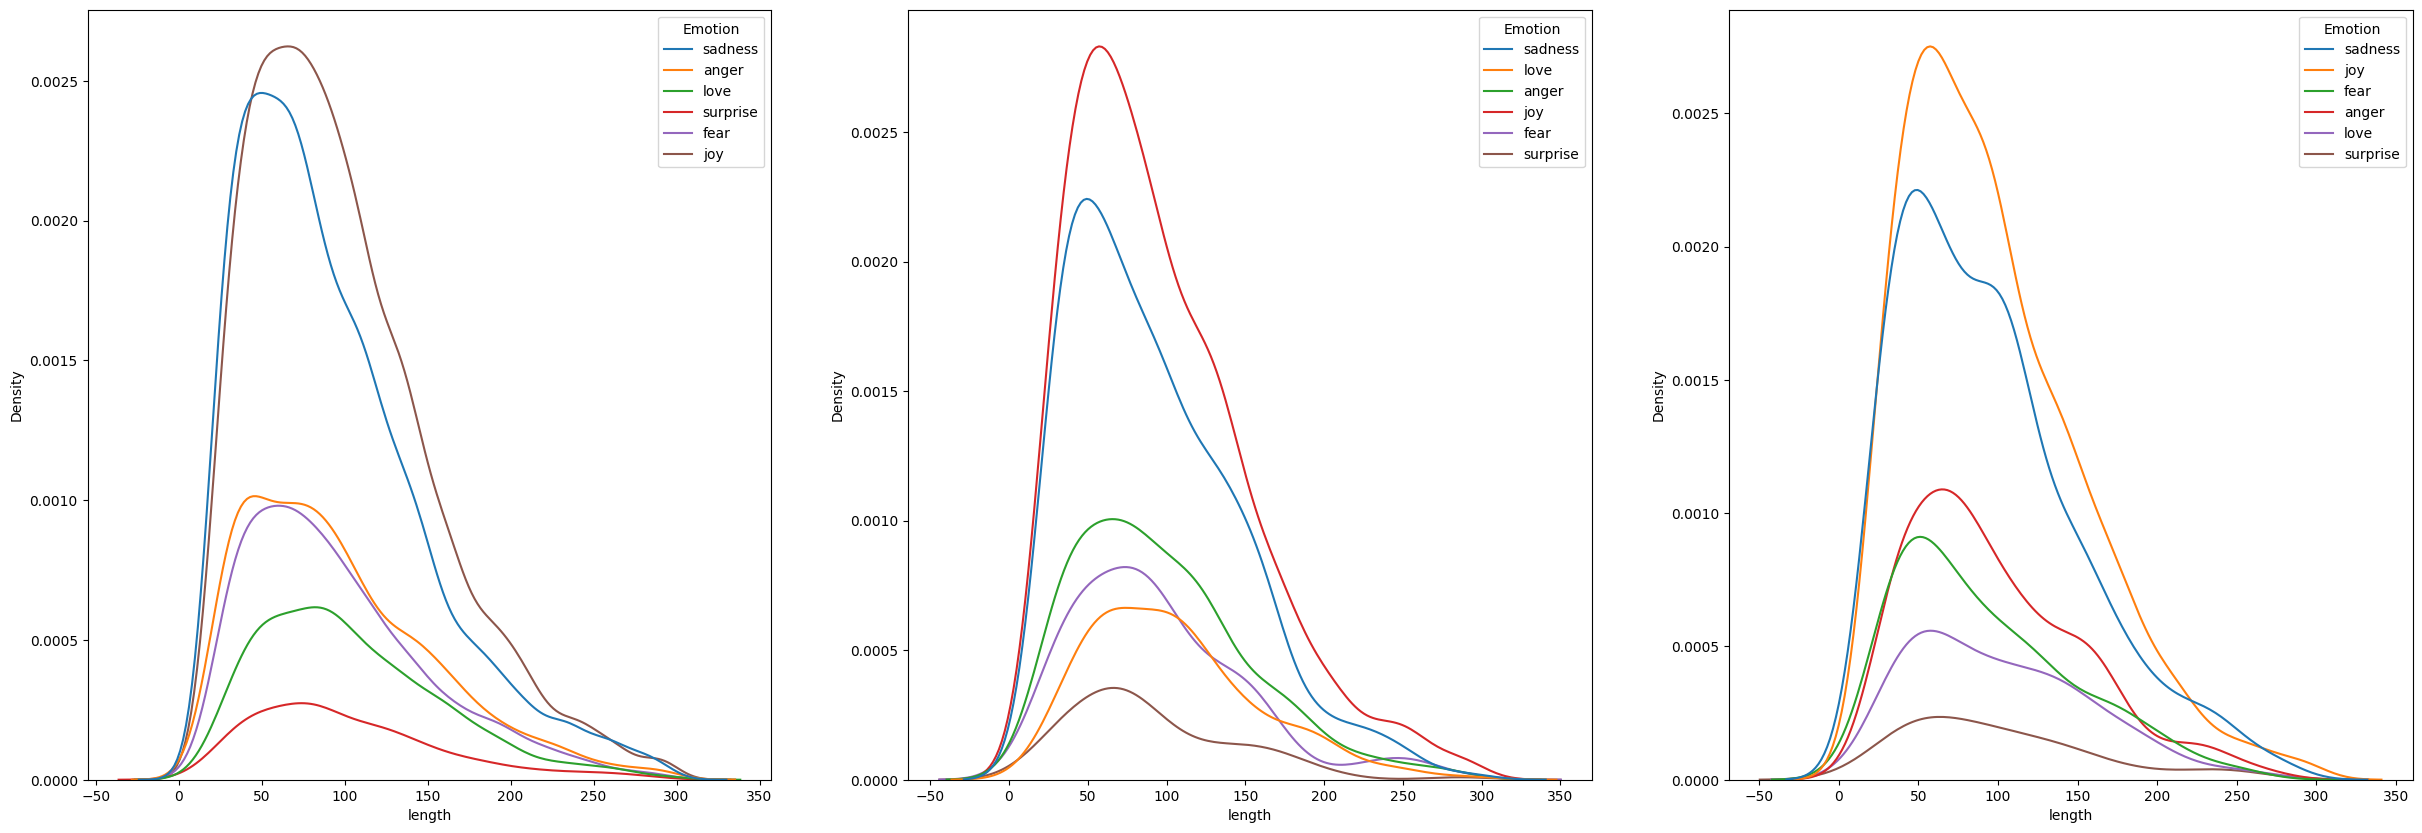

In [35]:
all_data = {'Train Data': train_data, 'Validation Data': validation_data, 'Test Data': test_data}
fig, ax = plt.subplots(1,3, figsize=(30,10))
for i, df in enumerate(all_data.values()):
    df2 = df.copy()
    df2['length'] = [len(x) for x in df2['Comment']]
    sns.kdeplot(data=df2,x='length',hue='Emotion', ax=ax[i])
plt.show()

In [110]:
def words_cloud(wordcloud, df):
    plt.figure(figsize=(5, 5))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")

### Words Cloud for each emotion

In [114]:
emotions_list = train_data['Emotion'].unique()
emotions_list

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

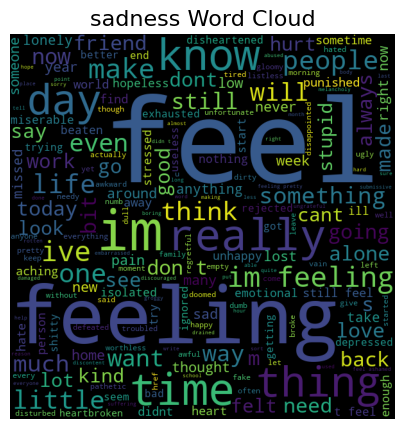

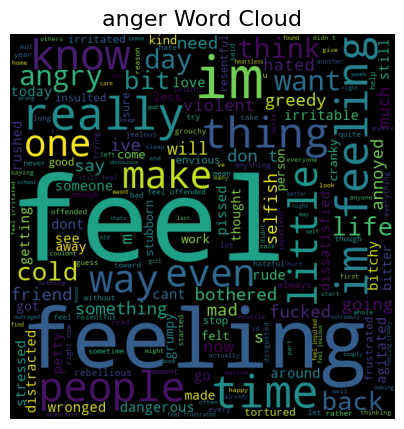

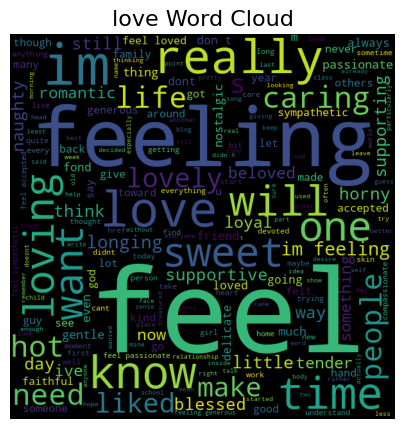

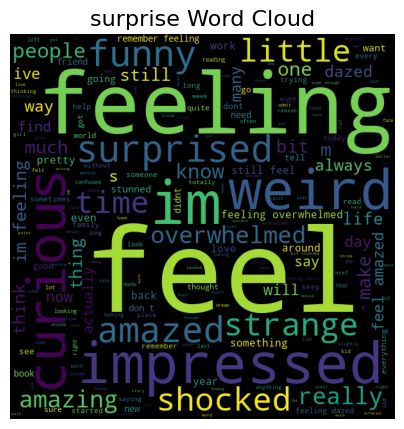

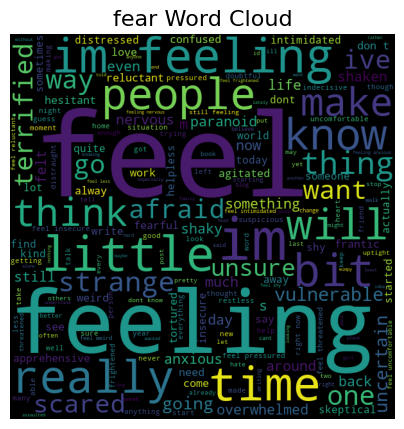

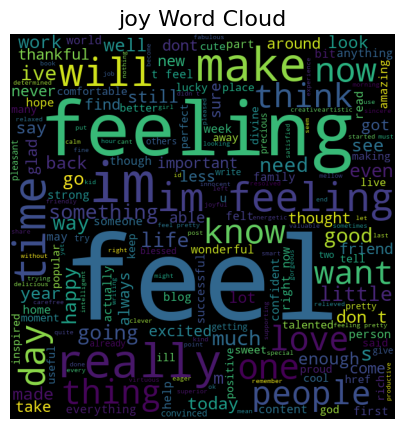

In [115]:
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

# Preprocessing

#### Label Encoding

In [154]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])
test_data['Emotion'] = lb.fit_transform(test_data['Emotion'])
validation_data['Emotion'] = lb.fit_transform(validation_data['Emotion'])

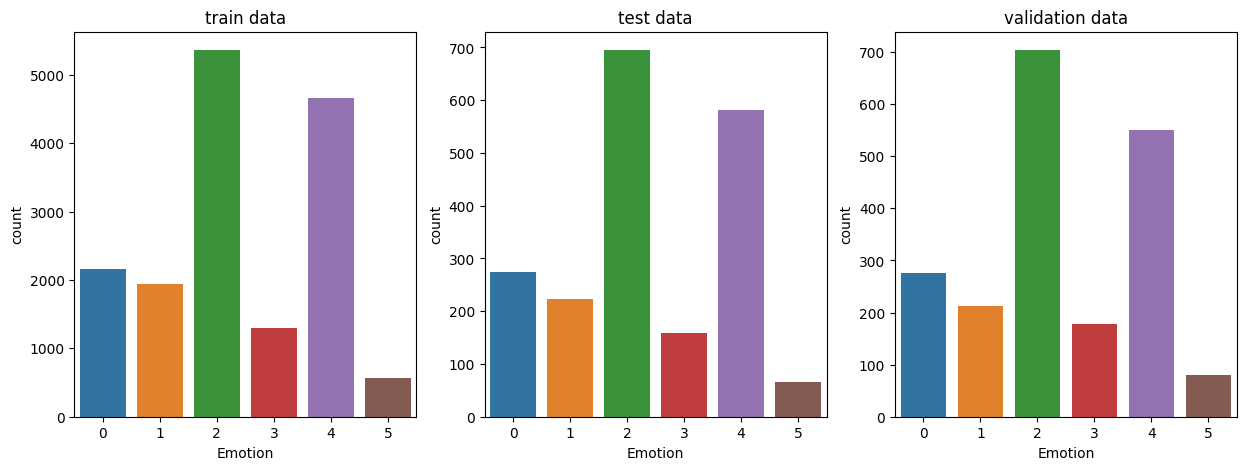

In [155]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
sns.countplot(x=train_data['Emotion'], ax=ax[0])
ax[0].set_title('train data')
sns.countplot(x=test_data['Emotion'], ax=ax[1])
ax[1].set_title('test data')
sns.countplot(x=validation_data['Emotion'], ax=ax[2])
ax[2].set_title('validation data')
plt.show()

In [156]:
print(lb.classes_)

['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']


In [157]:
train_data.head(2)

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108


#### Removing unrelevent stopwords and chars
Text cleaning fuction was inspired by this project - 
https://www.kaggle.com/muratkarakurt/emotion-detect-comment-97/notebook

In [125]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADIL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [151]:
max_len=train_data['length'].max()
max_len

300

In [45]:
vocabSize = 11000

In [173]:
from tensorflow.keras.preprocessing.text import one_hot
def text_cleaning(df, column):
    stemmer = PorterStemmer()
    corpus = []
    
    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if (word not in stopwords or word == 'not')]
        text = " ".join(text)
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocabSize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=max_len,padding='pre')
    print(pad.shape)
    return pad

In [159]:
x_train = text_cleaning(train_data, "Comment")
x_test = text_cleaning(test_data, "Comment")
x_val = text_cleaning(validation_data, "Comment")

(16000, 300)
(2000, 300)
(2000, 300)


In [161]:
y_train = train_data["Emotion"]
y_test = test_data["Emotion"]
y_val = validation_data["Emotion"]

In [163]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# Model building


In [52]:
model = Sequential()
model.add(Embedding(input_dim=vocabSize,output_dim=150,input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

In [53]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 150)          1650000   
                                                                 
 dropout_3 (Dropout)         (None, 300, 150)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               142848    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                

In [55]:
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

In [56]:
hist = model.fit(x_train,y_train,epochs=10,batch_size=64,
                 validation_data=(x_val,y_val), verbose=1, callbacks=[callback])

Epoch 1/10
250/250 [==============================] - 418s 2s/step - loss: 1.6045 - accuracy: 0.3333 - val_loss: 1.4041 - val_accuracy: 0.5150
Epoch 2/10
250/250 [==============================] - 430s 2s/step - loss: 0.9551 - accuracy: 0.6714 - val_loss: 0.6527 - val_accuracy: 0.7995
Epoch 3/10
250/250 [==============================] - 439s 2s/step - loss: 0.4503 - accuracy: 0.8590 - val_loss: 0.4729 - val_accuracy: 0.8370
Epoch 4/10
250/250 [==============================] - 443s 2s/step - loss: 0.2970 - accuracy: 0.8946 - val_loss: 0.4023 - val_accuracy: 0.8600
Epoch 5/10
250/250 [==============================] - 445s 2s/step - loss: 0.2180 - accuracy: 0.9243 - val_loss: 0.3696 - val_accuracy: 0.8775
Epoch 6/10
250/250 [==============================] - 448s 2s/step - loss: 0.1698 - accuracy: 0.9402 - val_loss: 0.4042 - val_accuracy: 0.8760
Epoch 7/10
250/250 [==============================] - 459s 2s/step - loss: 0.1422 - accuracy: 0.9544 - val_loss: 0.4296 - val_accuracy: 0.8780

In [57]:
model.evaluate(x_val,y_val,verbose=1)

63/63 [==============================] - 21s 323ms/step - loss: 0.3696 - accuracy: 0.8775


[0.36964547634124756, 0.8774999976158142]

In [58]:
model.evaluate(x_test,y_test,verbose=1)

63/63 [==============================] - 20s 323ms/step - loss: 0.3839 - accuracy: 0.8700


[0.3838854134082794, 0.8700000047683716]

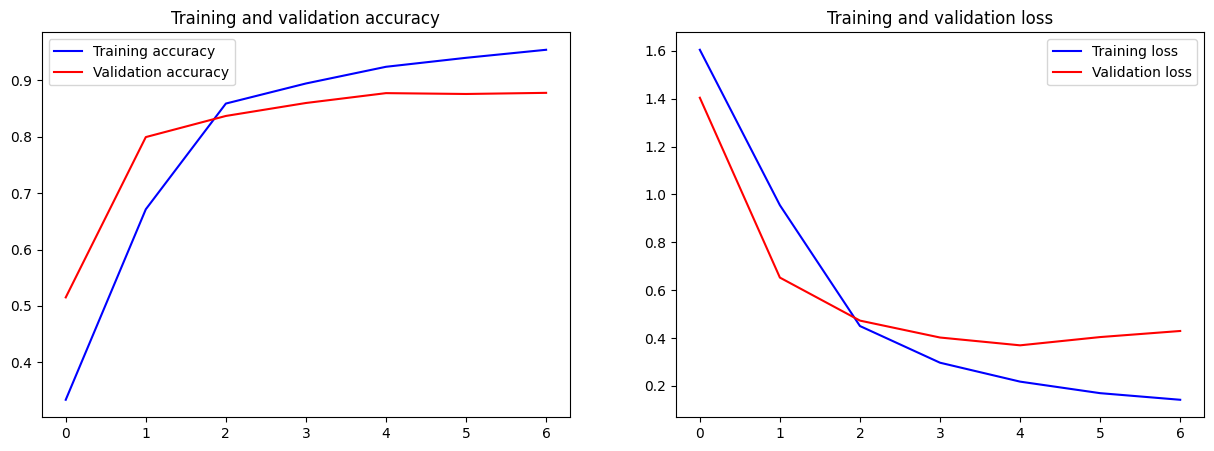

In [165]:
accuracy = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss=hist.history['loss']
val_loss=hist.history['val_loss']
epochs=range(len(accuracy))

fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(epochs,accuracy,'b', label='Training accuracy')
ax[0].plot(epochs,val_acc,'r', label='Validation accuracy')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs,loss,'b', label='Training loss')
ax[1].plot(epochs,val_loss,'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()

In [166]:
def sentence_cleaning(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if (word not in stopwords or word == 'not')]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocabSize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=300,padding='pre')
    return pad

In [170]:
sentences = [
             "Those teachers are really annoying i don't know what they excpect from us, this is frustrating",
             "i feel like a miserable piece of garbage",
             "i fear you"
            ]
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = model.predict(sentence)
    emotion_predict = np.argmax(result)
    emotion_class = lb.inverse_transform([emotion_predict])
    proba = np.max(result)
    print(f"{emotion_class} : {proba}\n\n")

Those teachers are really annoying i don't know what they excpect from us, this is frustrating
['teacher realli annoy know excpect us frustrat']
1/1 [==============================] - 0s 97ms/step
['anger'] : 0.9594288468360901


i feel like a miserable piece of garbage
['feel like miser piec garbag']
1/1 [==============================] - 0s 113ms/step
['sadness'] : 0.9944812059402466


i fear you
['fear']
1/1 [==============================] - 0s 109ms/step
['fear'] : 0.8614453077316284




The model could improve with more playing around with different kind of layers, more complex ones, I assume, but I tried to keep it simple in this project.

Overall not bad results.

In [62]:
model_saved = model.to_json()
with open("model_saved.json", "w") as json_file:
    json_file.write(model_saved)
model.save_weights("model_saved.h5")

In [63]:
with open('model_saved.json', 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model_saved.h5")

In [67]:
print(lb.classes_)

['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']


In [68]:
emotions_dict = {0:'Anger', 1:'Fear', 2:'Joy', 3:'Love', 4:'Sadness', 5:'Surprise'}

In [109]:
sentences = [
             "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
             "Those teachers are really annoying i don't know what they excpect from us, this is frustrating",
             "this is really romantic"
            ]
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = model.predict(sentence)
    emotion_result = emotions_dict[int(np.argmax(result))]
    proba =  np.max(result)
    print(f"{emotion_result} : {proba}\n\n")

He was speechles when he found out he was accepted to this new job
1/1 [==============================] - 0s 106ms/step
Love : 0.6062729358673096


This is outrageous, how can you talk like that?
1/1 [==============================] - 0s 136ms/step
Anger : 0.873799204826355


I feel like im all alone in this world
1/1 [==============================] - 0s 168ms/step
Sadness : 0.9866849780082703


He is really sweet and caring
1/1 [==============================] - 0s 183ms/step
Love : 0.90231853723526


Those teachers are really annoying i don't know what they excpect from us, this is frustrating
1/1 [==============================] - 0s 105ms/step
Anger : 0.9594288468360901


this is really romantic
1/1 [==============================] - 0s 82ms/step
Love : 0.6695560812950134




# Interface

In [172]:
from tkinter import *
from buttons import RoundedButton
from PIL import ImageTk, Image

def sentence_cleaning(sentence):
    global stopwords
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if (word not in stopwords or word == 'not')]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=300,padding='pre')
    return pad

# dictionary of the emotions
emotions_dict = {0:'Anger', 1:'Fear', 2:'Joy', 3:'Love', 4:'Sadness', 5:'Surprise'}

window = Tk()
window.title("Emotion detetctor")
window.geometry('600x500')
window.resizable(1,1)


label = Label(window, text="Welcome to emotion detector", font=("Arial Bold", 16))
label.pack(side=TOP, pady=30)



img = ImageTk.PhotoImage(Image.open(r"D:\AISciD(S6)\Deep_Learning\Project\button.png"))
feel = None
textfield = Text(window, width=40, font=('Arial', 12), bd=2, relief='groove', height=2)
textfield.pack(side=TOP, pady=10)
lb = Label(window, image=None, height=240)
lb_text = Label(window, text=None, font=("Arial Bold", 16))


def on_submit():
    text = textfield.get("1.0", "end-1c")
    text = sentence_cleaning(text)
    result = model.predict(text)
    emotion_result = int(np.argmax(result))
    proba =  np.max(result) * 100
    
    global lb
    global lb_text
    lb_text.destroy()
    feeling = ''
    if emotion_result == 0:
        feeling = 'angry'
        lb.destroy()
    elif emotion_result == 1:
        feeling = 'feared'
        lb.destroy()
    elif emotion_result == 2:
        feeling = 'happy'
        lb.destroy()
    elif emotion_result == 3:
        feeling = 'lover'
        lb.destroy()
    elif emotion_result == 4:
        feeling = 'sad'
        lb.destroy()
    elif emotion_result == 5:
        feeling = 'surprised'
        lb.destroy()

    gif_path = (f"D:\AISciD(S6)\Deep_Learning\Project\{feeling}.gif")
    print(f"file path = {gif_path}")
    
    image = Image.open(gif_path)
    # Resize the image
    image = image.resize((150, 150))
    # Create a PhotoImage object from the image
    photo = ImageTk.PhotoImage(image,  format="gif -index 2")
    lb = Label(window, image=photo, height=240)
    lb.image = photo
    lb.pack()
    lb_text = Label(window, text=f'You are : {proba:.2f}% {feeling}', font=("Arial Bold", 16))
    lb_text.pack(pady=10)
    textfield.delete("1.0", "end-1c")


button = Button(window, command = on_submit, image = img, border=0)
button.pack()





window.mainloop()



1/1 [==============================] - 0s 51ms/step
file path = D:\AISciD(S6)\Deep_Learning\Project\sad.gif
1/1 [==============================] - 0s 57ms/step
file path = D:\AISciD(S6)\Deep_Learning\Project\sad.gif
1/1 [==============================] - 0s 55ms/step
file path = D:\AISciD(S6)\Deep_Learning\Project\feared.gif
1/1 [==============================] - 0s 55ms/step
file path = D:\AISciD(S6)\Deep_Learning\Project\feared.gif
1/1 [==============================] - 0s 51ms/step
file path = D:\AISciD(S6)\Deep_Learning\Project\feared.gif
